# Аналіз US Stock Market 2020 to 2024

Імпорт залежностей.

In [1]:
import random
import warnings

import pandas as pd
import numpy as np

from skorch import NeuralNetRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from src.model.stock_mlp import StockMlp
from src.data.util.dataset import download_and_unzip
from src.util.fun import series_to_sliding_window
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import (
    plot_stock_prices,
    plot_stock_volumes,
    plot_value,
    plot_rolling_statistic,
    plot,
    plot_acf_and_pacf,
    plot_forecast,
)

warnings.simplefilter("ignore", InterpolationWarning)

random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

## Лабораторна робота №1

1. Обрати набір даних (датасет), який буде представляти собою часовий ряд (одновимірний або багатовимірний).
- Дата сет можна знайти на сайті kaggle, або будь який на ваш вибір, головне, щоб дані були репрезентативними і містили певну кількість записів для роботи з ними.

In [2]:
data_path = download_and_unzip(
    "dhavalpatel555",
    "us-stock-market-2020-to-2024",
    EXTERNAL_DATA_FOLDER,
)

df = pd.read_csv(data_path / "US Stock Market Dataset.csv")
df = df.rename({df.columns[0]: "id"}, axis=1)
df = df.set_index("id")
df = df.dropna(subset=["Date"])
df["Date"] = pd.to_datetime(
    df["Date"],
    format="mixed",
    dayfirst=True,
)
df = df.iloc[::-1]
df = df.replace(",", "", regex=True)

df["Bitcoin_Price"] = df["Bitcoin_Price"].astype(float)
df["Platinum_Price"] = df["Platinum_Price"].astype(float)
df["Ethereum_Price"] = df["Ethereum_Price"].astype(float)
df["S&P_500_Price"] = df["S&P_500_Price"].astype(float)
df["Nasdaq_100_Price"] = df["Nasdaq_100_Price"].astype(float)
df["Berkshire_Price"] = df["Berkshire_Price"].astype(float)
df["Gold_Price"] = df["Gold_Price"].astype(float)

df.head()

,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
id,,,,,,,,,,,,,,,,,,,,,
1012,2020-01-02,2.122,164570.0,61.18,486870.0,2.8250,72460.0,6967.0,632780,986.90,...,342261.0,410,329.81,4350000,94.90,80720000,209.78,12090000,1528.1,270550.0
1011,2020-01-03,2.130,144670.0,63.05,885860.0,2.7870,74750.0,7343.1,936290,988.55,...,339155.0,220,325.90,3800000,93.75,75330000,208.67,11200000,1552.4,436740.0
1010,2020-01-06,2.135,154680.0,63.27,724240.0,2.7900,59570.0,7759.1,786750,969.35,...,340210.0,280,335.83,5670000,95.14,81310000,212.60,17070000,1568.8,558970.0
1009,2020-01-07,2.162,163010.0,62.70,582650.0,2.7935,59470.0,8155.7,1010000,977.75,...,338901.0,280,330.75,4740000,95.34,82680000,213.06,15110000,1574.3,435870.0
1008,2020-01-08,2.141,242560.0,59.61,1210000.0,2.8120,77700.0,8059.6,1190000,961.00,...,339188.0,190,339.26,7110000,94.60,70240000,215.22,13490000,1560.2,813410.0


In [3]:
df.describe()

,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
count,1013,1013.000000,1009.000000,1013.000000,9.900000e+02,1013.000000,976.000000,1013.000000,1.013000e+03,1013.000000,...,1013.000000,1013.000000,1013.000000,1.013000e+03,1013.000000,1.013000e+03,1013.000000,1.013000e+03,1013.000000,1011.000000
mean,2022-01-18 19:55:29.911155200,3.726667,129091.932607,69.853475,3.571739e+05,3.726843,37606.752049,29215.594965,4.924137e+07,978.398371,...,424871.307009,2918.400790,422.035479,7.012043e+06,137.426209,7.452566e+07,252.151046,2.504895e+07,1839.171668,189442.393670
min,2020-01-02 00:00:00,1.482000,1200.000000,-37.630000,1.702000e+04,2.100500,10.000000,4826.000000,2.600000e+02,595.200000,...,240000.000000,120.000000,166.370000,1.140000e+06,81.820000,2.162000e+07,88.910000,5.470000e+06,1477.900000,0.000000
25%,2021-01-08 00:00:00,2.447000,88680.000000,54.760000,2.751800e+05,3.408000,380.000000,17180.100000,7.142000e+04,909.600000,...,349540.000000,760.000000,338.630000,3.780000e+06,114.770000,5.192000e+07,195.210000,1.612000e+07,1763.800000,142985.000000
50%,2022-01-20 00:00:00,2.880000,125980.000000,72.910000,3.450350e+05,3.800500,31635.000000,27634.900000,1.288800e+05,969.700000,...,432000.000000,2040.000000,431.600000,5.380000e+06,142.300000,6.515000e+07,262.010000,2.107000e+07,1835.800000,181200.000000
75%,2023-01-31 00:00:00,4.805000,164810.000000,82.810000,4.269225e+05,4.251500,70982.500000,40914.800000,3.860000e+05,1036.900000,...,481955.000000,4090.000000,509.640000,7.890000e+06,161.060000,8.683000e+07,313.190000,2.903000e+07,1936.600000,231500.000000
max,2024-02-02 00:00:00,9.647000,381970.000000,123.700000,1.770000e+06,4.937500,176040.000000,67527.900000,4.470000e+09,1297.100000,...,589498.000000,13850.000000,691.690000,1.333900e+08,186.570000,3.113500e+08,474.990000,2.304100e+08,2089.700000,813410.000000
std,NaN,1.943030,64035.426727,21.986697,1.864309e+05,0.646524,39192.315092,15115.630151,3.251389e+08,108.577041,...,82654.637405,2715.637488,119.765870,6.788094e+06,27.321896,3.376809e+07,72.949246,1.635122e+07,119.066900,104007.872337


2. Зобразіть часовий ряд графічно (одним графіком якщо це однокритеріальна задача, декількома - якщо багатокритеріальна).

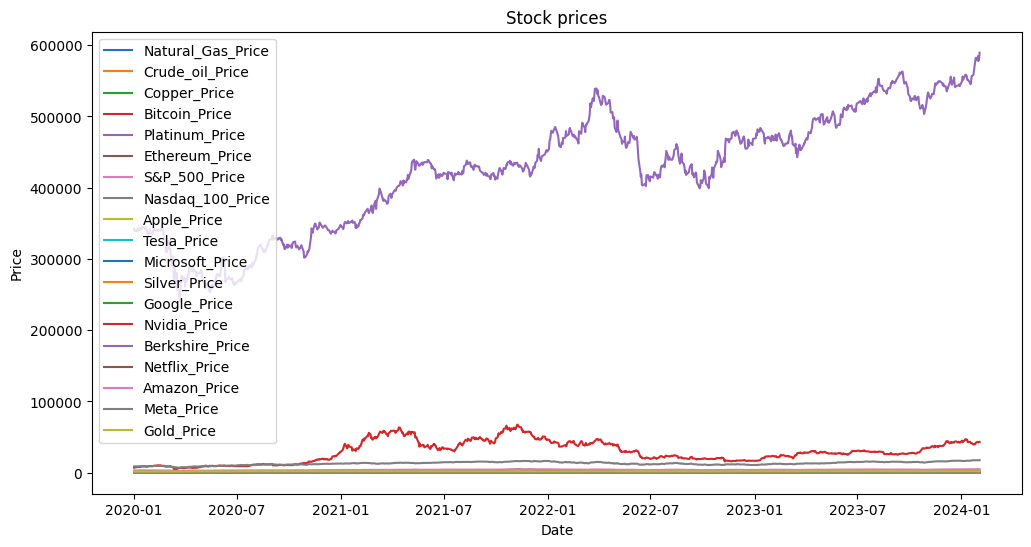

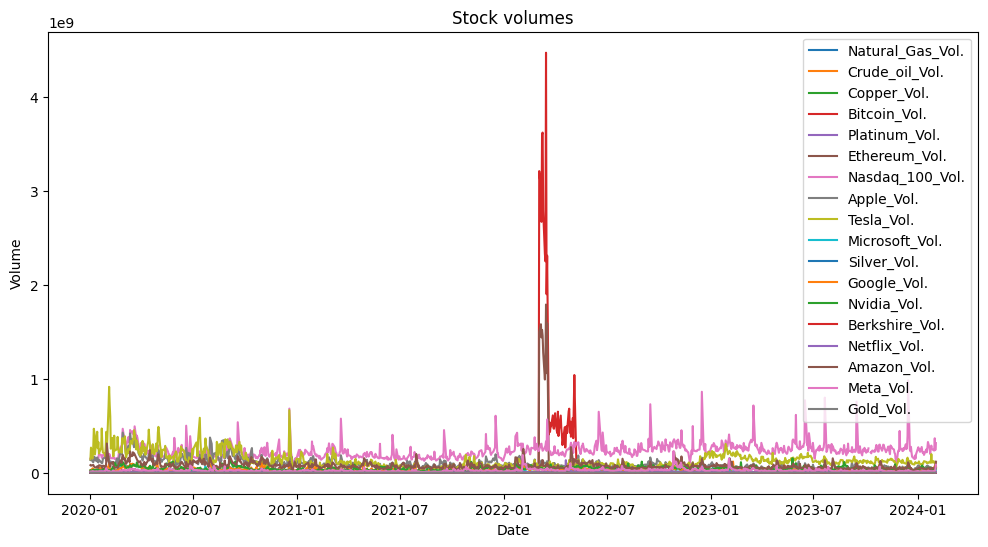

In [4]:
plot_stock_prices(df)
plot_stock_volumes(df)

3. Виконайте попередню обробку часового ряду:
- Перевірте дані на пропуски
- Виконайте фільтрацію даних часового ряду
- Зменшіть кількість атрибутів (у разі якщо це багатовимірний часовий ряд)

In [5]:
def check_date_dif(df):
    delta = df["Date"].diff()

    max_delta = delta.max()
    min_delta = delta.min()

    print(f"Max Delta: {max_delta}")
    print(f"Min Delta: {min_delta}")

In [6]:
check_date_dif(df)

Max Delta: 5 days 00:00:00
Min Delta: 1 days 00:00:00


In [7]:
df.set_index("Date", inplace=True)

full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")

df = df.reindex(full_range)

df.reset_index(inplace=True)
df.rename(columns={"index": "Date"}, inplace=True)

check_date_dif(df)

Max Delta: 1 days 00:00:00
Min Delta: 1 days 00:00:00


In [8]:
delta = df["Date"].diff()

max_delta = delta.max()
min_delta = delta.min()

print(f"Max Delta: {max_delta}")
print(f"Min Delta: {min_delta}")

Max Delta: 1 days 00:00:00
Min Delta: 1 days 00:00:00


In [9]:
df.isnull().sum()

Date                   0
Natural_Gas_Price    480
Natural_Gas_Vol.     484
Crude_oil_Price      480
Crude_oil_Vol.       503
Copper_Price         480
Copper_Vol.          517
Bitcoin_Price        480
Bitcoin_Vol.         480
Platinum_Price       480
Platinum_Vol.        857
Ethereum_Price       480
Ethereum_Vol.        480
S&P_500_Price        480
Nasdaq_100_Price     480
Nasdaq_100_Vol.      481
Apple_Price          480
Apple_Vol.           480
Tesla_Price          480
Tesla_Vol.           480
Microsoft_Price      480
Microsoft_Vol.       480
Silver_Price         480
Silver_Vol.          526
Google_Price         480
Google_Vol.          480
Nvidia_Price         480
Nvidia_Vol.          480
Berkshire_Price      480
Berkshire_Vol.       480
Netflix_Price        480
Netflix_Vol.         480
Amazon_Price         480
Amazon_Vol.          480
Meta_Price           480
Meta_Vol.            480
Gold_Price           480
Gold_Vol.            482
dtype: int64

In [10]:
for it in df.columns:
    df[it] = df[it].ffill()

df["Platinum_Vol."] = df["Platinum_Vol."].bfill()

df.isnull().sum()

Date                 0
Natural_Gas_Price    0
Natural_Gas_Vol.     0
Crude_oil_Price      0
Crude_oil_Vol.       0
Copper_Price         0
Copper_Vol.          0
Bitcoin_Price        0
Bitcoin_Vol.         0
Platinum_Price       0
Platinum_Vol.        0
Ethereum_Price       0
Ethereum_Vol.        0
S&P_500_Price        0
Nasdaq_100_Price     0
Nasdaq_100_Vol.      0
Apple_Price          0
Apple_Vol.           0
Tesla_Price          0
Tesla_Vol.           0
Microsoft_Price      0
Microsoft_Vol.       0
Silver_Price         0
Silver_Vol.          0
Google_Price         0
Google_Vol.          0
Nvidia_Price         0
Nvidia_Vol.          0
Berkshire_Price      0
Berkshire_Vol.       0
Netflix_Price        0
Netflix_Vol.         0
Amazon_Price         0
Amazon_Vol.          0
Meta_Price           0
Meta_Vol.            0
Gold_Price           0
Gold_Vol.            0
dtype: int64

In [11]:
df.describe()

,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
count,1493,1493.000000,1493.000000,1493.000000,1.493000e+03,1493.000000,1493.000000,1493.000000,1.493000e+03,1493.000000,...,1493.000000,1493.000000,1493.000000,1.493000e+03,1493.000000,1.493000e+03,1493.000000,1.493000e+03,1493.000000,1493.000000
mean,2022-01-17 00:00:00.000000256,3.731571,126105.123912,69.980764,3.515618e+05,3.729848,37443.348962,29194.460750,4.947202e+07,978.828533,...,424533.622907,2858.265238,421.926296,6.955419e+06,137.453188,7.634975e+07,252.071688,2.500271e+07,1839.277629,189440.857334
min,2020-01-02 00:00:00,1.482000,1200.000000,-37.630000,1.702000e+04,2.100500,10.000000,4826.000000,2.600000e+02,595.200000,...,240000.000000,120.000000,166.370000,1.140000e+06,81.820000,2.162000e+07,88.910000,5.470000e+06,1477.900000,0.000000
25%,2021-01-09 00:00:00,2.451000,86530.000000,54.190000,2.702200e+05,3.409000,390.000000,17125.700000,7.084000e+04,910.400000,...,350089.000000,740.000000,339.070000,3.790000e+06,114.560000,5.165000e+07,195.130000,1.598000e+07,1765.700000,142860.000000
50%,2022-01-17 00:00:00,2.893000,123020.000000,72.980000,3.442200e+05,3.806000,38000.000000,27581.400000,1.286400e+05,970.300000,...,432000.000000,2000.000000,431.600000,5.350000e+06,142.710000,6.554000e+07,262.010000,2.159000e+07,1834.600000,181150.000000
75%,2023-01-25 00:00:00,4.791000,162130.000000,82.820000,4.144300e+05,4.260000,69660.000000,40867.200000,3.886700e+05,1036.900000,...,481198.000000,4030.000000,510.400000,7.860000e+06,161.060000,8.855000e+07,313.260000,2.946000e+07,1935.900000,231110.000000
max,2024-02-02 00:00:00,9.647000,381970.000000,123.700000,1.770000e+06,4.937500,176040.000000,67527.900000,4.470000e+09,1297.100000,...,589498.000000,13850.000000,691.690000,1.333900e+08,186.570000,3.113500e+08,474.990000,2.304100e+08,2089.700000,813410.000000
std,NaN,1.938032,61757.350313,21.968767,1.846581e+05,0.646247,38576.390523,15070.879117,3.237723e+08,108.586427,...,82336.310654,2666.158009,120.117368,6.472505e+06,27.303874,3.693517e+07,72.845794,1.557043e+07,118.561235,103122.462657


## Лабораторна робота 2

1. Перевірити часовий ряд на стаціонарність/нестаціонарність за допомогою тестів.

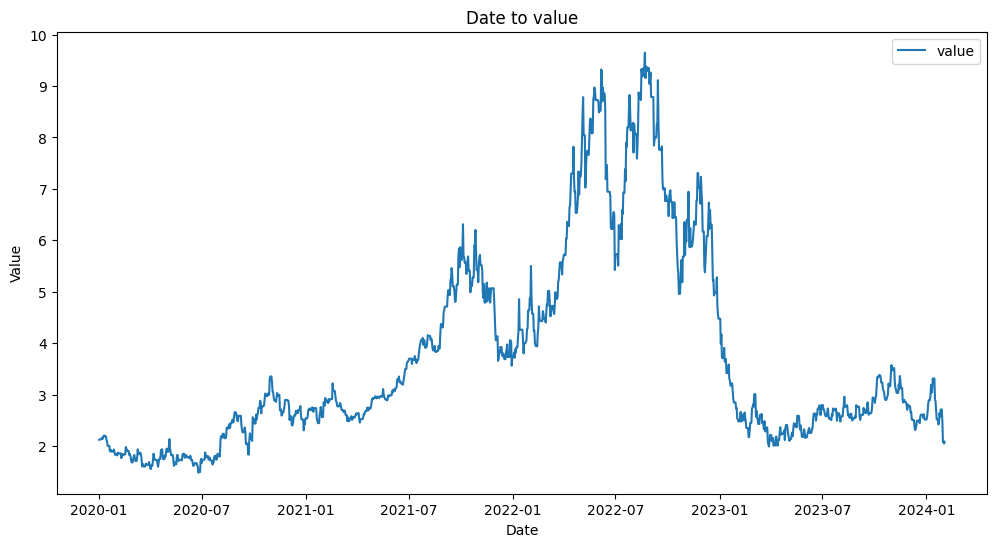

In [12]:
gas_series = df.set_index("Date")
gas_series = gas_series["Natural_Gas_Price"]
gas_series = gas_series.squeeze()
gas_series = gas_series.asfreq("D")

plot_value(gas_series)

In [13]:
def check_adf(series):
    adf_test = adfuller(series)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"P-value: {adf_test[1]}")
    if adf_test[1] < 0.05:
        print("Series is Stationary")
    else:
        print("Series is Non-Stationary")

In [14]:
def check_kpss(series):
    kpss_test, p_value, _, _ = kpss(series, regression="c")
    print(f"KPSS Statistic: {kpss_test}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("Series is Non-Stationary")
    else:
        print("Series is Stationary")

In [15]:
check_adf(gas_series)

ADF Statistic: -1.9292660797404182
P-value: 0.3184211152354404
Series is Non-Stationary


In [16]:
check_kpss(gas_series)

KPSS Statistic: 1.4034374894422075
P-value: 0.01
Series is Non-Stationary


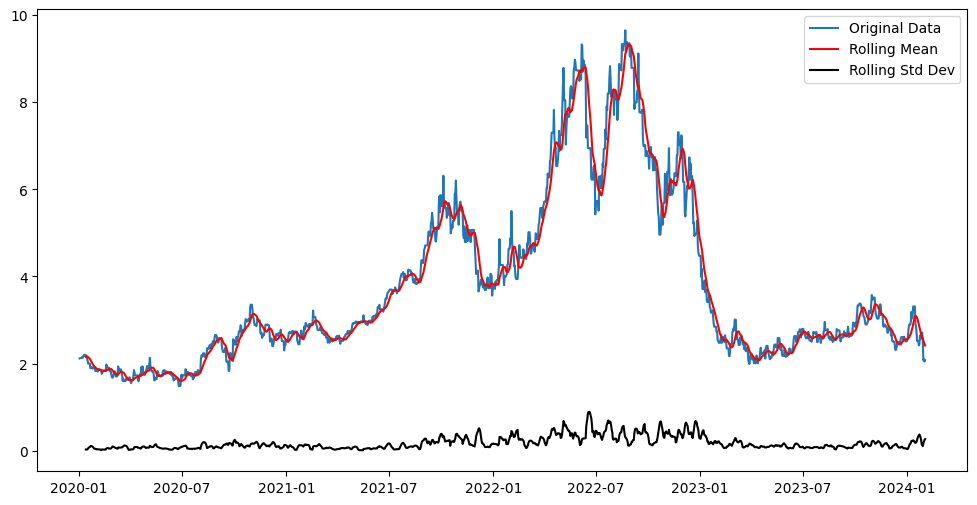

In [17]:
plot_rolling_statistic(gas_series)

2. Зробити декомпозицію часового ряду, визначити які складові містить часовий ряд.

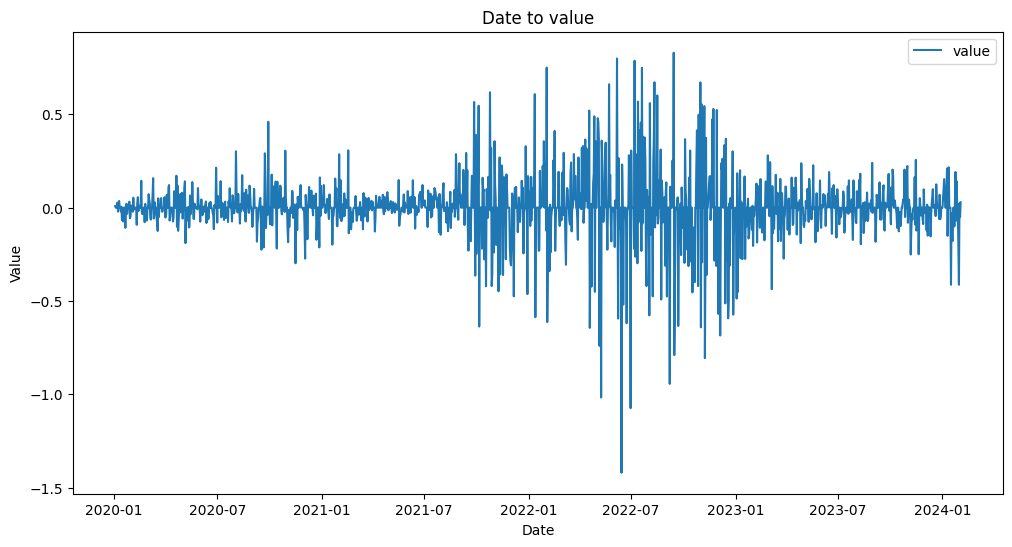

ADF Statistic: -14.84234451257238
P-value: 1.8290169151446553e-27
Series is Stationary
KPSS Statistic: 0.17613478671779897
P-value: 0.1
Series is Stationary


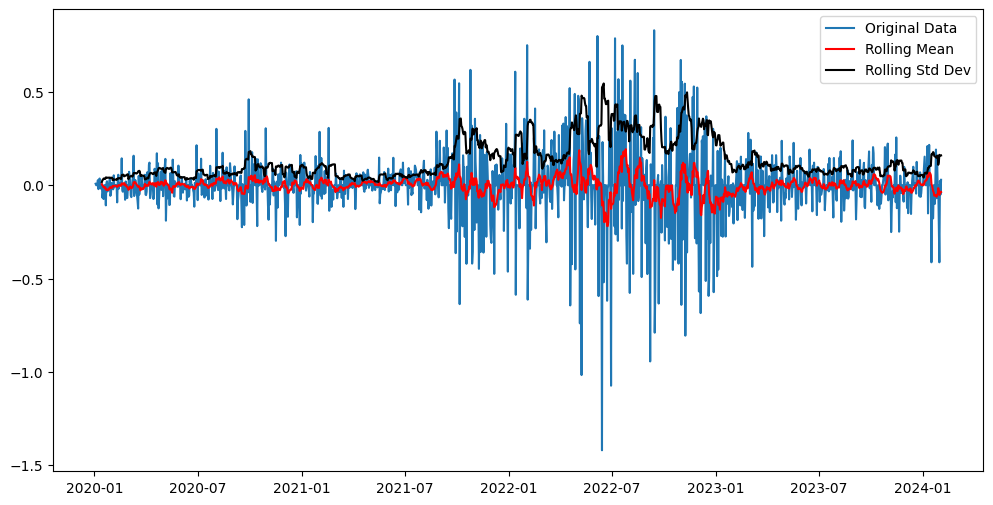

In [18]:
gas_series_diff = gas_series.diff().dropna()

plot(gas_series_diff)
check_adf(gas_series_diff)
check_kpss(gas_series_diff)
plot_rolling_statistic(gas_series_diff)

## Лабораторна робота 3

1. Обрати метод для прогнозування - базуючись на отриманих складових часового ряду, обрати моделі (обрати 2-3 моделі), за якими буде побудовано прогноз


2. Перевірити наявність гетероскедастичності часового ряду

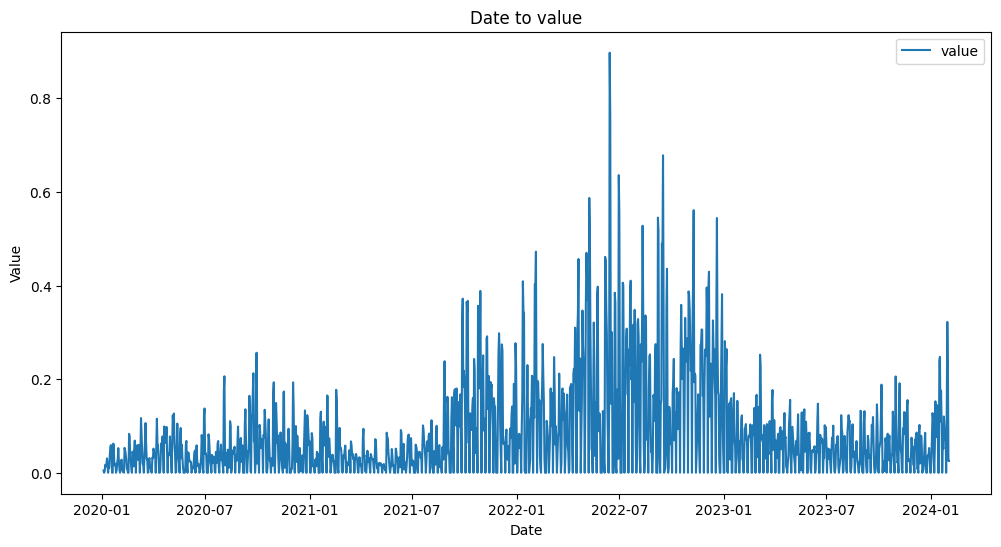

In [19]:
rolling_std = gas_series.rolling(window=3).std()

plot(rolling_std)

STD змінюється отже ряд - Гетероскедастичний

3. Побудувати модель 1: Перевірити показники якості моделі

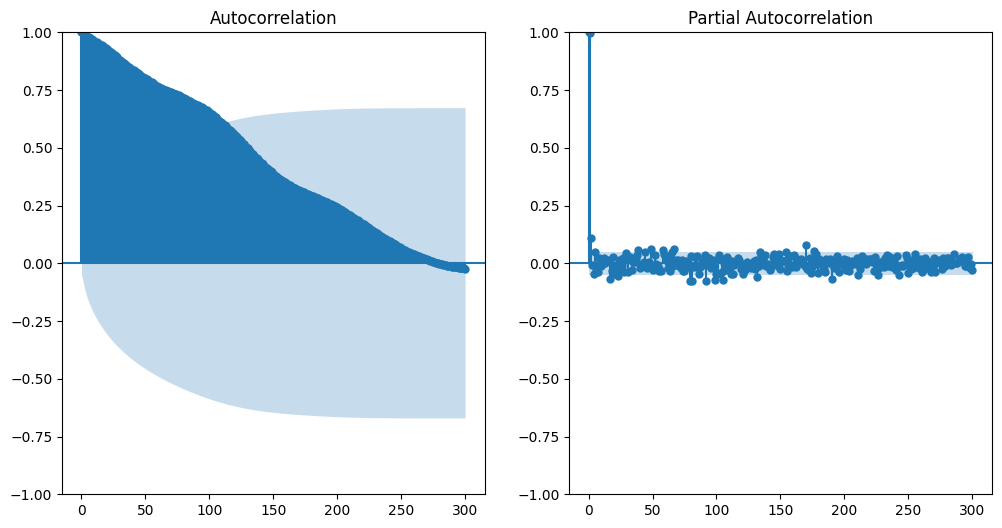

In [20]:
plot_acf_and_pacf(gas_series, lags=300)

In [21]:
train_size = int(len(gas_series) * 0.95)
train, test = gas_series.iloc[:train_size], gas_series.iloc[train_size:]

In [22]:
best_model = auto_arima(train, seasonal=False, trace=True)

best_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-964.777, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-938.638, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-961.681, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-960.894, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-940.614, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-957.947, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-958.372, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-968.575, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-961.031, Time=0.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-966.327, Time=0.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-964.004, Time=0.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-969.099, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-959.925, Time=0.31 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-967.094, Time=0.67 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1418
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 491.534
Date:                Thu, 06 Mar 2025   AIC                           -971.068
Time:                        22:22:48   BIC                           -939.531
Sample:                    01-02-2020   HQIC                          -959.286
                         - 11-19-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5510      0.028    -19.927      0.000      -0.605      -0.497
ar.L2         -0.9116      0.027    -33.607      0.000      -0.965      -0.858
ma.L1          0.4217      0.030     13.884      0.000       0.362       0.481
ma.L2          0.8852      0.022     40.630      0.000       0.843       0.928
ma.L3         -0.0966      0.018     -5.311      0.000      -0.132      -0.061
sigma2         0.0292      0.001     57.069      0.000       0.028       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5296.81
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.09   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
p = 2
d = 1
q = 3

In [24]:
model = ARIMA(train, order=(p, d, q))

model_fit = model.fit()

/Users/alexandermelashchenko/Workspace/time-series-forecasting/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4. Побудувати прогноз 1: Перевірити показники якості прогнозу

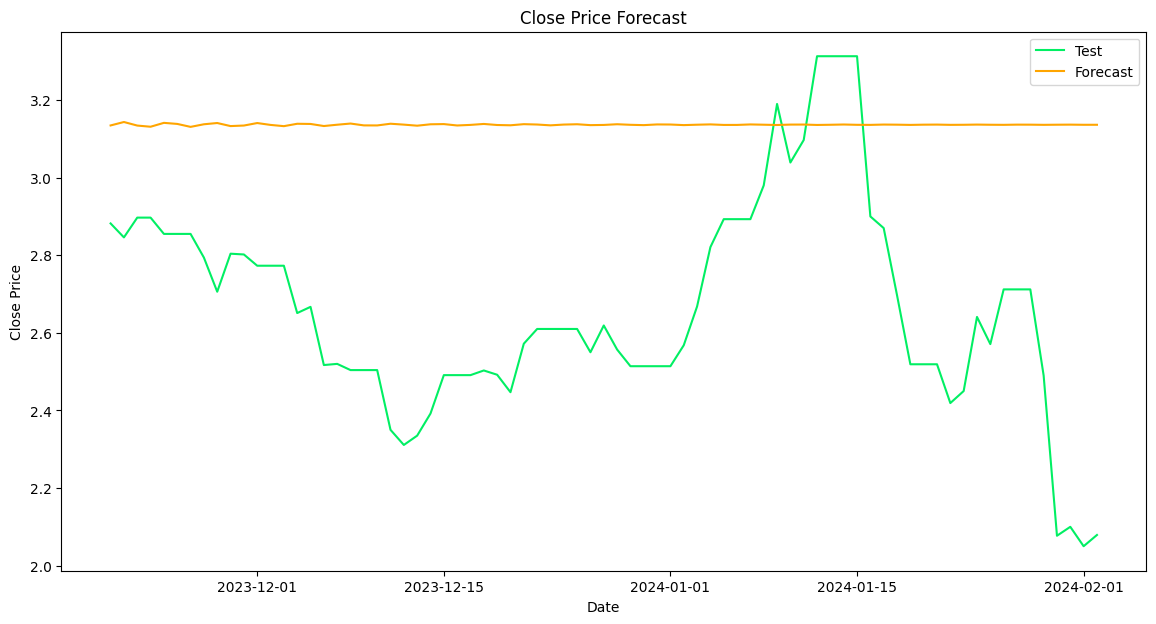

In [25]:
forecast = model_fit.forecast(steps=len(test))

plot_forecast(test, forecast)

5. Побудувати модель 2: Перевірити показники якості моделі

In [26]:
window_size = 10

x_train, y_train = series_to_sliding_window(train, window_size=window_size)
x_test, y_test = series_to_sliding_window(test, window_size=window_size)

In [27]:
params = {
    "lr": [0.01, 0.001, 0.0001],
}

regressor = NeuralNetRegressor(
    StockMlp(window_size, 1),
    max_epochs=300,
    lr=0.001,
)

search = GridSearchCV(regressor, params, scoring="r2", verbose=2)

search.fit(x_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       21.3812        0.0104  0.0191
      2      201.7407        8.3100  0.0118
      3       23.8837        4.5490  0.0108
      4       17.8173        1.9162  0.0117
      5       12.3671        0.2134  0.0102
      6       14.8536        2.1772  0.0110
      7       13.4461        0.6618  0.0232
      8       10.2764        0.1755  0.0164
      9        8.5159        0.0403  0.0123
     10        7.3529        0.0842  0.0112
     11        6.5113        0.2361  0.0102
     12        5.8724        0.4630  0.0103
     13        5.3723        0.7358  0.0113
     14        4.9961        0.9973  0.0115
     15        4.7409        1.2373  0.0102
     16        4.5590        1.4423  0.0119
     17        4.4303        1.6144  0.0109
     18        4.3284        1.7390  0.0109
     19        4.2453        1.8208  0.0115
     20        4

GridSearchCV(estimator=NeuralNetRegressor(_params_to_validate=set(), batch_size=128, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cpu', iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_valid=<class 'torch.utils.data.dataloader.DataLoader'>, lr=0.001, max_epochs=300, module=StockMlp(
  (model): Sequential(...
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
), optimizer=<class 'torch.optim.sgd.SGD'>, predict_nonlinearity='auto', torch_load_kwargs=None, train_split=<skorch.dataset.ValidSplit object at 0x2b5839150>, use_caching='auto', verbose=1, warm_start=False),
             param_grid={'lr': [0.01, 0.001, 0.0001]}, scoring='r2', verbose=2)

6. Побудувати прогноз 2: Перевірити показники якості прогнозу

In [28]:
y_pred = search.predict(x_test)

metrics.r2_score(y_test, y_pred)

0.913724422454834

In [29]:
search.best_params_

{'lr': 0.001}

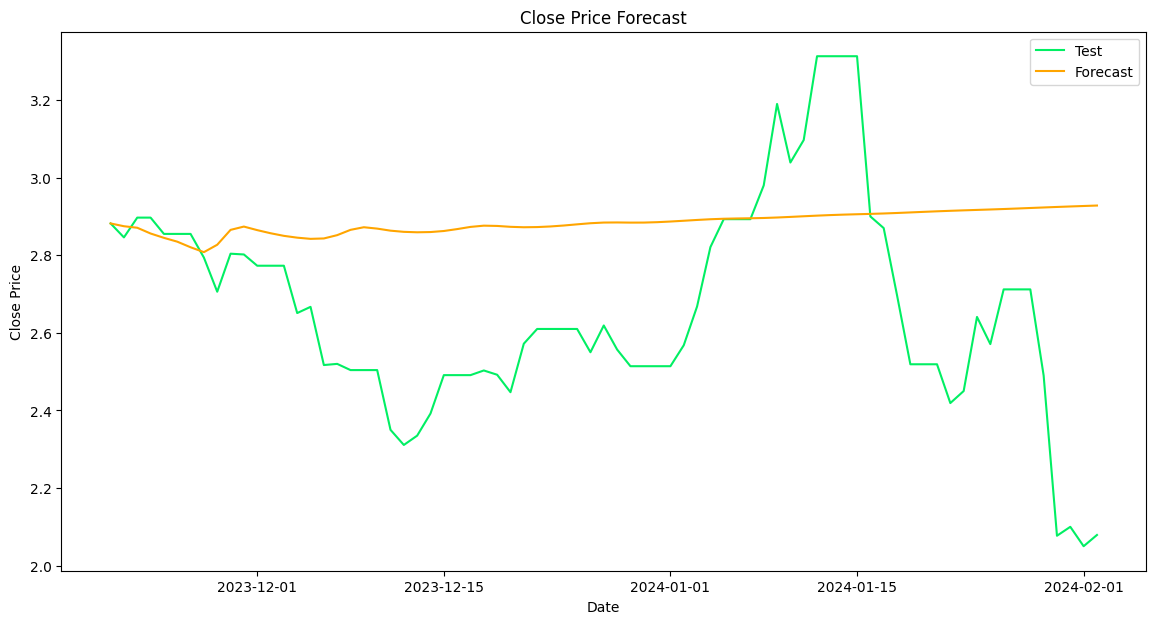

In [30]:
forecast = []
forecast_x = x_test[0].tolist()

while len(forecast) < len(test):
    next = search.predict(np.array(forecast_x, dtype=np.float32))[0]
    forecast.append(next)
    forecast_x.append(next)
    forecast_x.pop(0)

plot_forecast(test, forecast)